### SlideRule API

SlideRule is an on-demand science data processing service that runs in the cloud and responds to REST API calls to process and return science results.

SlideRule can be accessed by any http client (e.g. curl) by making GET and POST requests to the SlideRule service. For the purposes of this document, all requests to SlideRule will originate from a Python script using Python's requests module.

This notebook uses Jupyter widgets to set parameters for using the SlideRule API.
The widgets can be installed as described below.  
```bash
pip3 install --user ipywidgets
jupyter nbextension enable --py --user widgetsnbextension
jupyter-notebook
```

#### Load necessary packages

In [1]:
from sliderule import icesat2
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import ipywidgets as widgets

#### Configure SlideRule

In [2]:
# set the url for the sliderule service.
# eventually can make into widget if url becomes configurable
icesat2.init(["44.227.4.67"], True)

#### Set options for making science data processing requests to SlideRule

In [3]:
# dropdown menu for setting asset
AssetDropdown = widgets.Dropdown(
    options=['atlas-local', 'atlas-s3'],
    value='atlas-s3',
    description='Asset:',
    disabled=False,
)

# dropdown menu for file to process
# will replace options with file list
options = ['ATL03_20181019065445_03150111_003_01.h5']
value = ['ATL03_20181019065445_03150111_003_01.h5']
ResourceSelect = widgets.SelectMultiple(
    options=options,
    value=value,
    description='Resource:',
    disabled=False,
)

# selector for setting track
TrackSelect = widgets.SelectMultiple(
    options=['gt1','gt2','gt3'],
    value=['gt1'],
    description='Track:',
    disabled=False
)

# slider for setting length of ATL06 segment in meters
LengthSlider = widgets.IntSlider(
    value=40,
    min=5,
    max=200,
    step=10,
    description='Length:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# slider for setting step distance for successive segments in meters
StepSlider = widgets.IntSlider(
    value=20,
    min=5,
    max=200,
    step=5,
    description='Step:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


# slider for setting confidence level for PE selection
# eventually would be good to switch this to a IntRangeSlider with value=[0,4]
ConfSlider = widgets.IntSlider(
    value=4,
    min=0,
    max=4,
    step=1,
    description='Confidence:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


# slider for setting maximum number of iterations
# (not including initial least-squares-fit selection)
IterationSlider = widgets.IntSlider(
    value=1,
    min=0,
    max=20,
    step=1,
    description='Iterations:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# slider for setting minimum along track spread 
SpreadSlider = widgets.FloatSlider(
    value=20,
    min=1,
    max=100,
    step=0.1,
    description='Spread:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='0.1f'
)
# slider for setting minimum photon event (PE) count
CountSlider = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='PE Count:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# slider for setting minimum height of PE window in meters
WindowSlider = widgets.FloatSlider(
    value=3,
    min=0.5,
    max=10,
    step=0.1,
    description='Window:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='0.1f'
)

# slider for setting maximum robust dispersion in meters
SigmaSlider = widgets.FloatSlider(
    value=5,
    min=1,
    max=10,
    step=0.1,
    description='Sigma:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='0.1f'
)

# display widgets for setting SlideRule parameters
widgets.VBox([AssetDropdown,ResourceSelect,TrackSelect,LengthSlider,
    StepSlider,ConfSlider,IterationSlider,SpreadSlider,CountSlider,
    WindowSlider,SigmaSlider])

#### Build request and transmit request

In [4]:
# for each resource
# for now just use a single resource
resource = ResourceSelect.value[0]

# convert from 0-based to 1-based index
# for now just use a single track
# track = [t+1 for t in TrackSelect.index][0]
track = 0 # currently only supports all or one (0: all tracks)


asset = AssetDropdown.value,

parms = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water (default: 3)
    "srt": 3,
    # length of ATL06-SR segment in meters (default: 40.0)
    "len": LengthSlider.value,
    # step distance for successive ATL06-SR segments in meters (default: 20.0)
    "res": StepSlider.value,
    # confidence level for PE selection (default: 4)
    "cnf": ConfSlider.value,
    # maximum iterations, not including initial least-squares-fit selection (default: 1)
    "maxi": IterationSlider.value,
    # minimum along track spread (default: 20.0)
    "ats": SpreadSlider.value,
    # minimum PE count (default: 10)
    "cnt": CountSlider.value,
    # minimum height of PE window in meters (default: 3.0)
    "H_min_win": WindowSlider.value,
    # maximum robust dispersion in meters (default: 5.0)
    "sigma_r_max": SigmaSlider.value
}

# make the request to the SlideRule (ATL06-SR) endpoint
# and pass it the request parameters
rsps = icesat2.atl06(parms, resource, asset[0], as_numpy=True)

atl06 processing initiated on ATL03_20181019065445_03150111_003_01.h5 ...
... continuing to read ATL03_20181019065445_03150111_003_01.h5 (after 10 seconds)
processing of ATL03_20181019065445_03150111_003_01.h5 complete


#### Gather output variables and create remapped flattened arrays

#### Sort data and separate by spot

In [5]:
flattened = rsps
# create masked arrays sorted by segment id
segmin,segmax = (np.min(flattened['segment_id']),np.max(flattened['segment_id']))
# size of each segment compared to original ATL03 20m segments
dseg = StepSlider.value/20

# output remapped data
output = {}
# set segment_id and spot for output segments
nseg = int((segmax - segmin + 1)/dseg) + 1
output['segment_id'] = segmin + np.arange(nseg)*dseg
output['spot'] = np.unique(flattened['spot'])
nspot = len(output['spot'])
# for every other variable of interest
for key,dtype in zip(icesat2.keys[2:],icesat2.dtypes[2:]):
    output[key] = np.ma.zeros((nseg,nspot),dtype=dtype)
    output[key].mask = np.ones((nseg,nspot),dtype=bool)
    
# separate data for spots
for i,spot in enumerate(output['spot']):
    # indices of data for spot
    ind1, = np.nonzero(flattened['spot'] == spot)
    # sort data by segment ID
    sort1 = np.argsort(flattened['segment_id'][ind1])
    # create temporary sorted data for spot
    temp = {key:val[ind1][sort1] for key,val in flattened.items()}
    # indices to remap to output arrays
    ind2 = np.array((temp['segment_id']-segmin)/dseg,dtype=int)
    ind2 += np.array(np.arange(len(ind2)) % (1.0/dseg),dtype=int)
    # remap each variable
    for key,dtype in zip(icesat2.keys[2:],icesat2.dtypes[2:]):
        output[key].data[ind2,i] = temp[key]
        output[key].mask[ind2,i] = False

#### Create output plots

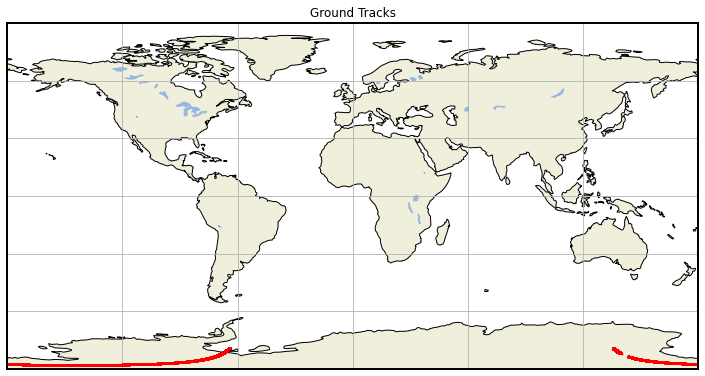

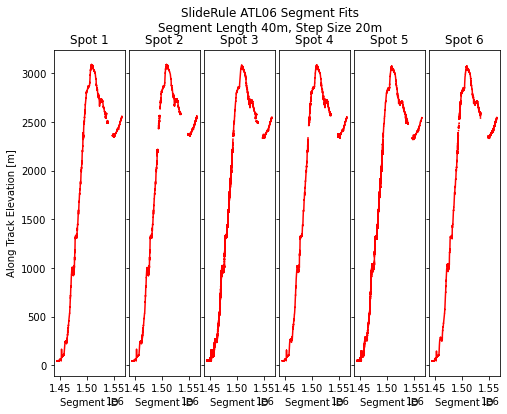

In [6]:
# output map of resource location
f1, ax1 = plt.subplots(num=1, nrows=1, ncols=1, figsize=(10,6),
    subplot_kw=dict(projection=cartopy.crs.PlateCarree()))
ax1.plot(output['lon'],output['lat'],'r.',ms=1,transform=cartopy.crs.Geodetic())
ax1.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())
# add coastlines with filled land and lakes
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES)
ax1.gridlines(xlocs=np.arange(-180.,181.,60.), ylocs=np.arange(-90.,91.,30.))
# add title
ax1.set_title('Ground Tracks')
# stronger linewidth on frame
ax1.spines['geo'].set_linewidth(2.0)
ax1.spines['geo'].set_capstyle('projecting')
# adjust subplot within figure
f1.subplots_adjust(left=0.02,right=0.98,bottom=0.05,top=0.98)

# output plot of fit height for each segment
f2, ax2 = plt.subplots(num=2,ncols=nspot,sharey=True,figsize=(8,6))
for j,spot in enumerate(output['spot']):
    ax2[j].plot(output['segment_id'],output['h_mean'][:,j],'r')
    ax2[j].set_xlabel('Segment ID')
    ax2[j].set_title('Spot {0:d}'.format(spot))
ax2[0].set_ylabel('Along Track Elevation [m]')
title = 'SlideRule ATL06 Segment Fits\nSegment Length {0:d}m, Step Size {1:d}m'
f2.suptitle(title.format(LengthSlider.value,StepSlider.value))
f2.subplots_adjust(wspace=0.05)

# show plots
plt.show()